<a href="https://colab.research.google.com/github/Stefi96/DetectingNFTs-Master/blob/main/Metadata_NFTs_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Necessary imports
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score
import xgboost as xgb
from gensim.models import Word2Vec

In [11]:
# Load the datasets
legit_data = pd.read_csv('/content/drive/MyDrive/Master/Project/Metadata/nft_data_legit.csv',low_memory=False)
scam_data = pd.read_csv('/content/drive/MyDrive/Master/Project/Metadata/scam_nft_data_full.csv')

legit_data['label'] = 0  # assuming 0 is the label for legitimate data
scam_data['label'] = 1  # assuming 1 is the label for scam data

# Feature Intersection
#common_columns = set(legit_data.columns) & set(scam_data.columns)

In [12]:
# Distribution of unique values in name and symbol columns for both datasets
legit_name_unique_count = legit_data['name'].nunique()
scam_name_unique_count = scam_data['name'].nunique()

legit_symbol_unique_count = legit_data['symbol'].nunique()
scam_symbol_unique_count = scam_data['symbol'].nunique()

legit_name_unique_count, scam_name_unique_count, legit_symbol_unique_count, scam_symbol_unique_count

(7907, 239, 712, 177)

In [13]:
# Prepare textual data
legit_textual_data = legit_data[['json_description', 'label']]
legit_textual_data = legit_textual_data.rename(columns={"json_description": "content"})
scam_textual_data = scam_data[['json_description', 'label']]
scam_textual_data = scam_textual_data.rename(columns={"json_description": "content"})
combined_textual_data = pd.concat([legit_textual_data, scam_textual_data], axis=0, ignore_index=True)

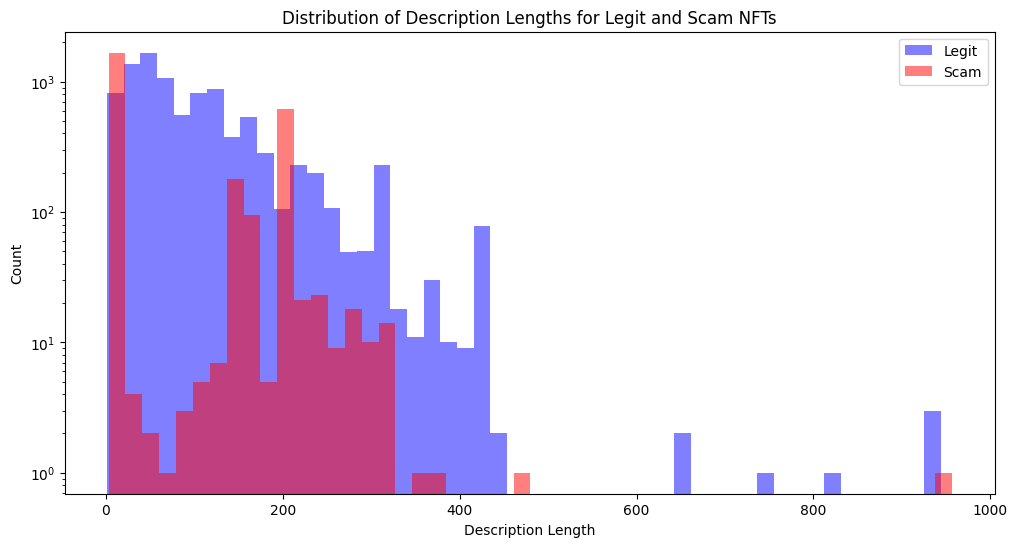

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the distribution of description lengths for 'legit' and 'scam' classes using Matplotlib
plt.figure(figsize=(12, 6))

# Extracting description lengths for legit NFTs from the 'content' column
legit_description_lengths_direct = legit_textual_data['content'].apply(lambda x: len(str(x)))
# Extracting description lengths for legit NFTs from the 'content' column
scam_description_lengths_direct = scam_textual_data['content'].apply(lambda x: len(str(x)))

# Plotting legit descriptions
plt.hist(legit_description_lengths_direct, bins=50, color='blue', alpha=0.5, label='Legit')

# Plotting scam descriptions
plt.hist(scam_description_lengths_direct, bins=50, color='red', alpha=0.5, label='Scam')

plt.title('Distribution of Description Lengths for Legit and Scam NFTs')
plt.xlabel('Description Length')
plt.ylabel('Count')
plt.yscale('log')  # Using a logarithmic scale for better visibility
plt.legend()
plt.show()




In [15]:
from textblob import TextBlob

# Define a function to get sentiment from TextBlob
def get_sentiment(text):
    analysis = TextBlob(str(text))
    # Classify the polarity
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

# Calculate sentiment for both datasets
legit_data['sentiment'] = legit_data['json_description'].apply(get_sentiment)
scam_data['sentiment'] = scam_data['json_description'].apply(get_sentiment)

# Get sentiment distribution for both datasets
legit_sentiment_distribution = legit_data['sentiment'].value_counts(normalize=True)
scam_sentiment_distribution = scam_data['sentiment'].value_counts(normalize=True)

legit_sentiment_distribution, scam_sentiment_distribution

(neutral     0.533600
 positive    0.366863
 negative    0.099537
 Name: sentiment, dtype: float64,
 neutral     0.700858
 positive    0.289817
 negative    0.009325
 Name: sentiment, dtype: float64)

In [16]:
# Apply TF-IDF transformation
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, stop_words='english', max_features=1000)
combined_textual_data['content'].fillna("", inplace=True)
tfidf_features = tfidf_vectorizer.fit_transform(combined_textual_data['content'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_features, combined_textual_data['label'], test_size=0.2, random_state=42, stratify=combined_textual_data['label']
)

In [17]:
# Train and evaluate a Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

# Train and evaluate an XGBoost model
xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False, random_state=42)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)
print(classification_rep_xgb)

# Train and evaluate a Random Forest model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)
print(classification_rep_rf)

# Train and evaluate an SVM model
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)
print(classification_rep_svm)

# Calculate macro-averaged metrics for Logistic Regression
lr_macro_precision = precision_score(y_test, y_pred, average='macro')
lr_macro_recall = recall_score(y_test, y_pred, average='macro')
lr_macro_f1 = f1_score(y_test, y_pred, average='macro')
print(lr_macro_f1)

# Calculate macro-averaged metrics for XGBoost
xgb_macro_precision = precision_score(y_test, y_pred_xgb, average='macro')
xgb_macro_recall = recall_score(y_test, y_pred_xgb, average='macro')
xgb_macro_f1 = f1_score(y_test, y_pred_xgb, average='macro')
print(xgb_macro_f1)

# Calculate macro-averaged metrics for Random Forest
rf_macro_precision = precision_score(y_test, y_pred_rf, average='macro')
rf_macro_recall = recall_score(y_test, y_pred_rf, average='macro')
rf_macro_f1 = f1_score(y_test, y_pred_rf, average='macro')
print(rf_macro_f1)

# Calculate macro-averaged metrics for SVM
svm_macro_precision = precision_score(y_test, y_pred_svm, average='macro')
svm_macro_recall = recall_score(y_test, y_pred_svm, average='macro')
svm_macro_f1 = f1_score(y_test, y_pred_svm, average='macro')
print(svm_macro_f1)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1899
           1       0.77      0.99      0.87       536

    accuracy                           0.93      2435
   macro avg       0.89      0.96      0.91      2435
weighted avg       0.95      0.93      0.94      2435



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1899
           1       0.75      0.99      0.85       536

    accuracy                           0.92      2435
   macro avg       0.87      0.95      0.90      2435
weighted avg       0.94      0.92      0.93      2435

              precision    recall  f1-score   support

           0       1.00      0.92      0.95      1899
           1       0.77      0.99      0.87       536

    accuracy                           0.93      2435
   macro avg       0.88      0.95      0.91      2435
weighted avg       0.95      0.93      0.94      2435

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1899
           1       0.76      1.00      0.87       536

    accuracy                           0.93      2435
   macro avg       0.88      0.96      0.91      2435
weighted avg       0.95      0.93      0.93      2435

0.9131971730032256


In [18]:
# 1. Data Loading
legit_data = pd.read_csv('/content/drive/MyDrive/Master/Project/Metadata/nft_data_legit.csv', low_memory=False)
scam_data = pd.read_csv('/content/drive/MyDrive/Master/Project/Metadata/scam_nft_data_full.csv')

# Add label column: 0 for legit, 1 for scam
legit_data['label'] = 0
scam_data['label'] = 1

In [19]:
legit_data

,model,updateAuthorityAddress,json_name,json_symbol,json_description,json_seller_fee_basis_points,json_creators_0_address,json_creators_0_share,json_image,json_category,...,json_consumption_23_foodAddress,json_consumption_23_foodRank,json_consumption_24_foodAddress,json_consumption_24_foodRank,json_consumption_25_foodAddress,json_consumption_25_foodRank,json_properties_date,json_properties_type,json_properties_level,label
0,nft,B7vgVrV8BqHQST8Nn8iWT5jNkJ1PswyZAAbLwDwpJEbq,Hasuki #9293,HSKI,Hasukis Vibing On Solana,990.0,NaN,100.0,https://nftstorage.link/ipfs/bafybeib7z3rbaodr...,image,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,nft,Ase9PHQ7oKeTKZqtRvxRa48QigMKhbusMsr1KiHJXsPt,Citizen 1#286,CITIZEN,"Guests for Solsteads, and an expansion into th...",500.0,NaN,NaN,https://arweave.net/cdsKt--ICv0S8Rolo4f6BQU8iA...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,nft,HVQTKbAmQYBpxSE5sXRNgMtuhDQ7t1ewFpvAGwzAUmFM,Galactic Gecko #6841,GGSG,"With the help of your Targari brothers, you've...",500.0,NaN,NaN,https://www.arweave.net/DsssCXGYyrOUUc09-TIPdk...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,nft,6wUuTsWNR3thQWJ1X1PzuKEXN6ER67qJbMrkyqkS1psz,Ordinem #1443,ORD,"Ordinem, a collection of 2222 valiant knights ...",750.0,NaN,NaN,https://ipfs.io/ipfs/bafybeibtqg2msiojno62m77i...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,nft,CKingvicTB6KmpyG2UBQbQbXe69DhnmgKXxksrpjpa8u,CatchKing Explorer #2763,CK,"CatchKing Explorers is a series of 5,555 NFT's...",600.0,NaN,NaN,https://arweave.net/QolAahHrpsuX_42OtzvNuoR28V...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9489,nft,ENbfsjziQs66HoQXr3yV6JKMAxmGxYd3dMUvK8Vt4KL9,Netrunner #1901,SNR,"4646 Netrunners. Wired in, running on Solana",800.0,NaN,NaN,https://bafybeigllntkzrdjzcrcnb72ft44ryay2nijs...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9490,nft,26fiGgrti5iXisuk7VkhiWz3Me4s5DeA8ehcgb6rw4dp,Unchained MEC #2624,MECS,MECs - Unchained's genesis collection. Customi...,999.0,NaN,NaN,https://bafybeiaxvf27r4jbddbvak6yt6krt4evptqud...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9491,nft,5nY6efT87mbEAA2b52SrSAqUoFCBef2jwpJSWQ6VxSyJ,Vibe Knights #7516,VIBE,"8888 Anime Elves, One Global IP.",500.0,NaN,NaN,https://nftstorage.link/ipfs/bafybeihjssblkjyf...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9492,nft,26fiGgrti5iXisuk7VkhiWz3Me4s5DeA8ehcgb6rw4dp,Unchained MEC #4188,MECS,MECs - Unchained's genesis collection. Customi...,999.0,NaN,NaN,https://bafybeidbctmdqj6velgsjl3dem4qbsp54ul4o...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [20]:
# Rename the desired columns for textual data processing
legit_data.rename(columns={"json_description": "content"}, inplace=True)
scam_data.rename(columns={"json_description": "content"}, inplace=True)

# Combine the datasets
combined_data = pd.concat([legit_data[['content', 'label']], scam_data[['content', 'label']]], axis=0).reset_index(drop=True)

# 2. Text Preprocessing
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\W+|\d+', ' ', text)
    text = ' '.join(word for word in text.split() if word not in ENGLISH_STOP_WORDS and len(word) > 2)
    return text

combined_data['processed_content'] = combined_data['content'].apply(preprocess_text)

In [21]:
# Check the columns of legit_data, scam_data, and combined_data
print("Columns in legit_data:", legit_data.columns)
print("Columns in scam_data:", scam_data.columns)
print("Columns in combined_data:", combined_data.columns)


Columns in legit_data: Index(['model', 'updateAuthorityAddress', 'json_name', 'json_symbol',
       'content', 'json_seller_fee_basis_points', 'json_creators_0_address',
       'json_creators_0_share', 'json_image', 'json_category',
       ...
       'json_consumption_23_foodAddress', 'json_consumption_23_foodRank',
       'json_consumption_24_foodAddress', 'json_consumption_24_foodRank',
       'json_consumption_25_foodAddress', 'json_consumption_25_foodRank',
       'json_properties_date', 'json_properties_type', 'json_properties_level',
       'label'],
      dtype='object', length=590)
Columns in scam_data: Index(['model', 'updateAuthorityAddress', 'json', 'jsonLoaded', 'name',
       'symbol', 'uri', 'isMutable', 'primarySaleHappened',
       'sellerFeeBasisPoints', 'editionNonce', 'creators', 'tokenStandard',
       'collection', 'collectionDetails', 'uses', 'programmableConfig',
       'address', 'metadataAddress', 'mint_model', 'mint_address',
       'mint_mintAuthorityAddress'

In [22]:
# 3. Text Representation using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, stop_words='english', max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(combined_data['processed_content'])

# 4. Using Word Embeddings
tokenized_content = combined_data['processed_content'].apply(lambda x: x.split())
model = Word2Vec(sentences=tokenized_content, vector_size=300, window=5, min_count=1, workers=4)
model.train(tokenized_content, total_examples=len(tokenized_content), epochs=10)

# Function to get the vector for a document using word2vec model
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv.key_to_index]
    if len(doc) == 0:
        return np.zeros(word2vec_model.vector_size)
    else:
        return np.mean(word2vec_model.wv[doc], axis=0)

# Convert the documents to vectors
doc_vectors = np.array([document_vector(model, doc) for doc in tokenized_content])

In [23]:
# 5. Splitting the data and training the model using TF-IDF representations
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, combined_data['label'], test_size=0.2, random_state=42)

In [24]:
clf_tfidf = SVC(max_iter=1000)
clf_tfidf.fit(X_train, y_train)
y_pred_tfidf = clf_tfidf.predict(X_test)
f1_tfidf = f1_score(y_test, y_pred_tfidf)

# 6. Splitting the data and training the model using Word2Vec representations
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(doc_vectors, combined_data['label'], test_size=0.2, random_state=42)

clf_w2v = SVC(max_iter=1000)
clf_w2v.fit(X_train_w2v, y_train_w2v)
y_pred_w2v = clf_w2v.predict(X_test_w2v)
f1_w2v = f1_score(y_test_w2v, y_pred_w2v)

f1_tfidf, f1_w2v

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


(0.8635235732009925, 0.8706677937447168)

In [25]:
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 23.6 MB/s eta 0:00:00


In [26]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel, Trainer, TrainingArguments
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import json

In [27]:
# Handle missing values and ensure all data is of type string

# Ensure all data is of type string
X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]

# Convert to List if they are pandas Series
y_train = y_train.tolist() if isinstance(y_train, pd.Series) else y_train
y_test = y_test.tolist() if isinstance(y_test, pd.Series) else y_test

# Check for NaN or Inf Values
assert not any(torch.isnan(torch.tensor(y_train)))
assert not any(torch.isnan(torch.tensor(y_test)))

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# # Now tokenize
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512)

# Ensure Matching Lengths
assert len(train_encodings['input_ids']) == len(y_train)
assert len(test_encodings['input_ids']) == len(y_test)


In [28]:
# Create a torch dataset
class NFTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NFTDataset(train_encodings, y_train)
test_dataset = NFTDataset(test_encodings, y_test)

In [29]:
# Initialize the model
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
def convert_to_embeddings(encodings, model, batch_size=256):
    embeddings = []

    # Loop through the encodings in batches
    for i in range(0, len(encodings['input_ids']), batch_size):
        batch = torch.tensor(encodings['input_ids'][i:i+batch_size])
        with torch.no_grad():
            batch_embeddings = model(batch)[0].mean(dim=1).numpy()
        embeddings.append(batch_embeddings)

    # Concatenate all batch embeddings
    return np.concatenate(embeddings, axis=0)

# Convert tokenized encodings to embeddings using DistilBERT in smaller batches
X_train_embeddings = convert_to_embeddings(train_encodings, bert_model)
X_test_embeddings = convert_to_embeddings(test_encodings, bert_model)

# Apply PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_embeddings)
X_test_pca = pca.transform(X_test_embeddings)

# Convert the PCA embeddings back to the format required by the Trainer class
train_dataset = NFTDataset({'input_ids': X_train_pca}, y_train)
test_dataset = NFTDataset({'input_ids': X_test_pca}, y_test)

In [ ]:
# # Define training arguments and train
# training_args = TrainingArguments(
#     output_dir='./results',
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     logging_dir='./logs',
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset
# )

# trainer.train()

# # Evaluate
# results = trainer.evaluate()

In [ ]:
# Define training arguments and train
training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=10,  # Log every 10 steps
    save_steps=10,    # Save checkpoint every 10 steps
    evaluation_strategy="steps"  # Evaluate every logging_steps
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

# Evaluate
results = trainer.evaluate()

In [ ]:
# Parse the logs
log_file = "./logs/trainer_state.json"
with open(log_file, 'r') as f:
    logs = [json.loads(line) for line in f]

train_loss = [log['loss'] for log in logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]

# Plot the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.tight_layout()
plt.show()